# What time & space scales are important <br> for metrics of interest to ETBF fishery models?

## Author(s)
**Thomas Moore**

- Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

**References**
<br>This notebook directly follows this EarthCube open-source example:<br>
Martin and Abernathey 2021. Frequency-Domain Analysis of Large Datasets. Accessed at https://github.com/earthcube2021/ec21_martin_etal

## Background

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Aenean hendrerit sapien ante. Praesent pulvinar enim a ante facilisis, at egestas sapien gravida. Proin dignissim molestie efficitur. Nunc feugiat nisl eu congue eleifend. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Nullam et lorem et lorem molestie fringilla.

## Methodology

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Aenean hendrerit sapien ante. Praesent pulvinar enim a ante facilisis, at egestas sapien gravida. Proin dignissim molestie efficitur. Nunc feugiat nisl eu congue eleifend. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Nullam et lorem et lorem molestie fringilla.


## Results
Lorem ipsum dolor sit amet, consectetur adipiscing elit. Aenean hendrerit sapien ante. Praesent pulvinar enim a ante facilisis, at egestas sapien gravida. Proin dignissim molestie efficitur. Nunc feugiat nisl eu congue eleifend. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Nullam et lorem et lorem molestie fringilla.


#### Funding

- funding1 = {"agency": "", "award_code": "", "award_URL": ""}

#### Keywords

keywords=["","",""]

#### Citation

Moore 2021

#### Acknowledgements 

We thank the Pangeo community for developing and maintaining most of the packages used in this notebook.  The notebook layout was directly inspired and built from EarthCube templates.

# Setup

## Library import

In [1]:
# Reading in data

# Data manipulation
import xarray as xr
import dask.array as dsa
from rechunker import rechunk
import xrft
import numpy as np
import scipy

# Distributed computing
from dask_jobqueue import SLURMCluster
from distributed import Client


# Visualization
import matplotlib.pyplot as plt

# autocomplete fix
%config Completer.use_jedi = False

## helper functions import

In [2]:
#local functions
import importlib
import helper_tools as helper
importlib.reload(helper)

<module 'helper_tools' from '/OSM/CBR/OA_DCFP/work/moo270/code/helper-py/helper_tools.py'>

### Set up **Dask** cluster



In [3]:
cluster = SLURMCluster(cores=4,
                       memory="24GB",
                       walltime="2:00:00",
                       job_extra=['--qos="express"'],
                       processes=1
                      )

In [4]:
#how many workers do you want?
cluster.scale_up(n=7)

In [5]:
client = Client(cluster)

In [6]:
client

Client Scheduler: tcp://10.141.0.117:43439 Dashboard: http://10.141.0.117:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


# Data import, processing, and analysis

## Step 1: Open and rechunk the original data

This dataset is stored on HPC and are intermediate products from upstream raw output

### load the data

In [7]:
# load CAFE60 ETBF metrics
ds_MLH = xr.open_zarr('/OSM/CBR/OA_DCFP/work/moo270/ETBF_CAFE_data/ETBF_intermediate_products/CAFE60_MLH.zarr',consolidated=True)
ds_MLH

<xarray.Dataset>
Dimensions:   (time: 360, xt_ocean: 360, yt_ocean: 300)
Coordinates:
  * time      (time) object 1990-01-16 12:00:00 ... 2019-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
Data variables:
    MLH       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(360, 300, 360), meta=np.ndarray>

Let's make a quick plot to see what the data look like.
Pre-coarsening makes the plot faster to load.

Text(0.5, 1.0, 'CAFE60 MLH snapshot')

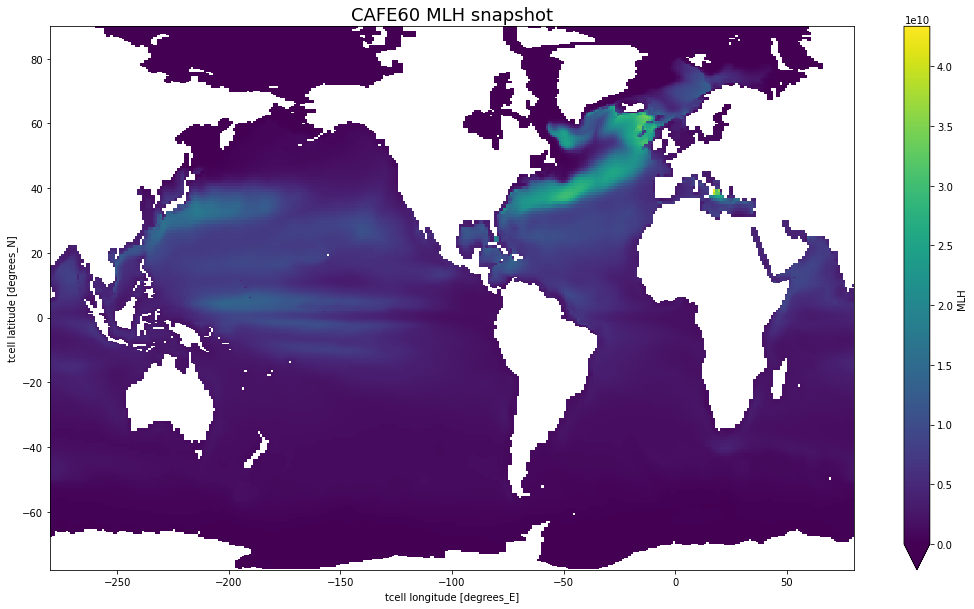

In [11]:
ds_MLH.MLH[0].coarsen(xt_ocean=1, yt_ocean=1).mean().plot(figsize=(18, 10),vmin=0)
plt.title('CAFE60 MLH snapshot',fontsize=18)

Note the chunk structure of the original data: contiguous in the spatial dimension and chunked in the time dimension.
This is not optimal for frequency-domain spectral analysis.

In [12]:
ds_MLH

<xarray.Dataset>
Dimensions:   (time: 360, xt_ocean: 360, yt_ocean: 300)
Coordinates:
  * time      (time) object 1990-01-16 12:00:00 ... 2019-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
Data variables:
    MLH       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(360, 300, 360), meta=np.ndarray>

## examine timeseries at different locations

Is there a need to normalise / standardise input signal to power spectrum calculation?  Should we use the anomaly from climatological mean (probably)?


In [ ]:
tropics_MLH = ds_MLH.sel({'xt_ocean':-180.0,'yt_ocean':-5},method='nearest')
EAC_MLH = ds_MLH.sel({'xt_ocean':-206.0,'yt_ocean':-27},method='nearest')

In [ ]:
EAC_MLH.MLH.plot()
tropics_MLH.MLH.plot(color='r')

***

## Step 2: Compute the power spectrum of MLH

The power spectrum is defined as follows, where a hat denotes a Fourier transform and the star denotes a complex conjugate.

$$
\widehat{MLH}^* \widehat{MLH}
$$

### Define function to take power spectrum (includes detrending step)

In [7]:
def take_power_spectrum(var,real_arg):
    '''
    Martin and Abernathey 2021. 
    Frequency-Domain Analysis of Large Datasets
    https://github.com/earthcube2021/ec21_martin_etal
    '''   
    var = var.chunk({'time':None}) # there can be no chunking in the time dimension
    var_filled = var.fillna(0) # fill NaNs with zeros
    
    # Take power spectrum in the time domain, setting time to be a real dimension, with both a linear detrend and a windowing function
    var_hat = xrft.power_spectrum(var_filled,dim='time',real=real_arg,detrend='linear',window=True)
    
    return var_hat

### convert time axis to integer time counter

In [14]:
integer_months = np.arange(1,1+ds_MLH.time.size,1,dtype=int)
ds_MLH['time'] = integer_months

### Compute the power spectrum of MLH

In [15]:
# Call the function
MLH_calc_power_spectrum = take_power_spectrum(ds_MLH.MLH,'time')

# Take only the real output
MLH_power_spectrum = MLH_calc_power_spectrum.real
MLH_power_spectrum

/scratch1/moo270/miniconda3/envs/pangeo_xgcm/lib/python3.9/site-packages/xrft/xrft.py:684: FutureWarning: `real` flag will be deprecated in future version of xrft.power_spectrum and replaced by `real_dim` flag.
  warnings.warn(msg, FutureWarning)
/scratch1/moo270/miniconda3/envs/pangeo_xgcm/lib/python3.9/site-packages/xrft/xrft.py:347: FutureWarning: `real` flag will be deprecated in future version of xrft.dft and replaced by `real_dim` flag.
  warnings.warn(msg, FutureWarning)
/scratch1/moo270/miniconda3/envs/pangeo_xgcm/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


<xarray.DataArray (freq_time: 181, yt_ocean: 300, xt_ocean: 360)>
dask.array<real, shape=(181, 300, 360), dtype=float64, chunksize=(181, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean   (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean   (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * freq_time  (freq_time) float64 0.0 0.002778 0.005556 ... 0.4944 0.4972 0.5

### Load Some Results

So far, all of our calculations have been "lazy".
No computation has actually happened yet.
In order to load some data, we will subset the data to a size that can fit into our notebook's memory.
We select a region in the North Atlantic.

In [16]:
region = dict(yt_ocean=slice(-60,0), xt_ocean=slice(-220, -170))
MLH_power_spectrum_SEPAC = MLH_power_spectrum.sel(**region)
MLH_power_spectrum_SEPAC

<xarray.DataArray (freq_time: 181, yt_ocean: 94, xt_ocean: 50)>
dask.array<getitem, shape=(181, 94, 50), dtype=float64, chunksize=(181, 94, 50), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean   (xt_ocean) float64 -219.5 -218.5 -217.5 ... -172.5 -171.5 -170.5
  * yt_ocean   (yt_ocean) float64 -59.93 -59.22 -58.5 ... -0.5005 -0.1662
  * freq_time  (freq_time) float64 0.0 0.002778 0.005556 ... 0.4944 0.4972 0.5

### compute results

In [17]:
%%time
MLH_power_spectrum_SEPAC = MLH_power_spectrum_SEPAC.compute()

CPU times: user 337 ms, sys: 37.3 ms, total: 374 ms
Wall time: 5.09 s


In [18]:
%%time
MLH_power_spectrum = MLH_power_spectrum.compute()

CPU times: user 404 ms, sys: 204 ms, total: 608 ms
Wall time: 4.78 s


***

## Step 3: Plot Results

### Area Average Power Spectrum

<ipython-input-19-dd8e32557638>:15: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axes.set_xlim(xmin=0)


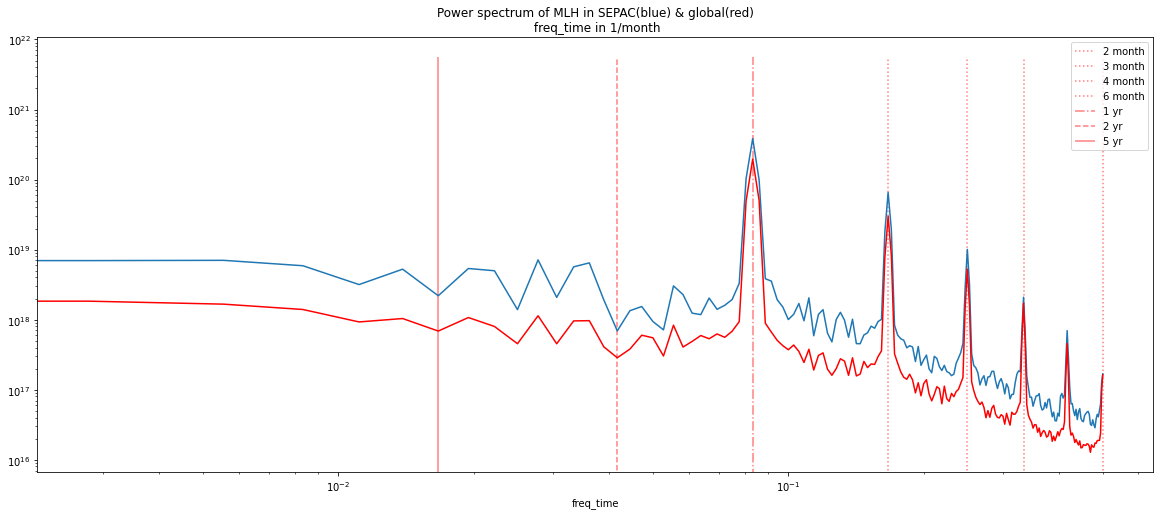

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(20,8))
max_value = MLH_power_spectrum_SEPAC.max()
MLH_power_spectrum_SEPAC.mean(dim=('xt_ocean', 'yt_ocean')).plot(ax=axes)
MLH_power_spectrum.mean(dim=('xt_ocean', 'yt_ocean')).plot(color='r',ax=axes)
plt.title('Power spectrum of MLH in SEPAC(blue) & global(red)\n freq_time in 1/month')
axes.set_xscale("log") #scale transformation
axes.set_yscale("log") #scale transformation
axes.vlines((1/2),0,max_value,'r',alpha=0.5,linestyles='dotted', label='2 month')
axes.vlines((1/3),0,max_value,'r',alpha=0.5,linestyles='dotted', label='3 month')
axes.vlines((1/4),0,max_value,'r',alpha=0.5,linestyles='dotted', label='4 month')
axes.vlines((1/6),0,max_value,'r',alpha=0.5,linestyles='dotted', label='6 month')
axes.vlines((1/12),0,max_value,'r',alpha=0.5,linestyles='dashdot', label='1 yr')
axes.vlines((1/24),0,max_value,'r',alpha=0.5,linestyles='dashed', label='2 yr')
axes.vlines((1/60),0,max_value,'r',alpha=0.5,linestyles='solid', label='5 yr')
axes.set_xlim(xmin=0)
axes.legend()

### spectra at a point in the tropics and EAC

<ipython-input-20-10b3bcef7592>:16: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axes.set_xlim(xmin=0)


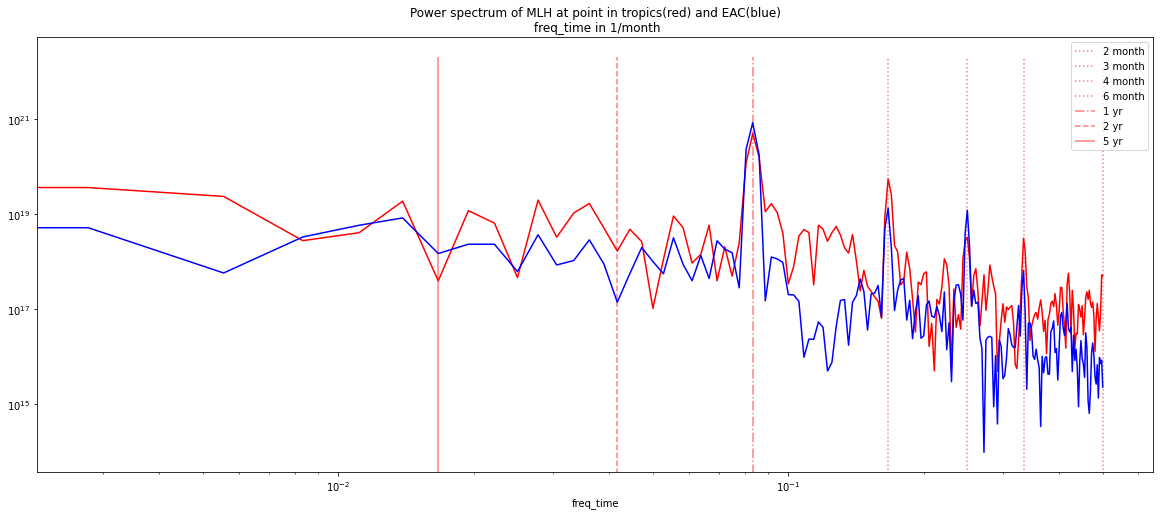

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(20,8))
max_value = MLH_power_spectrum.max()

MLH_power_spectrum.sel({'xt_ocean':-180.0,'yt_ocean':-5},method='nearest').plot(color='r',ax=axes)
MLH_power_spectrum.sel({'xt_ocean':-206.0,'yt_ocean':-27},method='nearest').plot(color='b',ax=axes)
plt.title('Power spectrum of MLH at point in tropics(red) and EAC(blue)\n freq_time in 1/month')
axes.set_xscale("log") #scale transformation
axes.set_yscale("log") #scale transformation
axes.vlines((1/2),0,max_value,'r',alpha=0.5,linestyles='dotted', label='2 month')
axes.vlines((1/3),0,max_value,'r',alpha=0.5,linestyles='dotted', label='3 month')
axes.vlines((1/4),0,max_value,'r',alpha=0.5,linestyles='dotted', label='4 month')
axes.vlines((1/6),0,max_value,'r',alpha=0.5,linestyles='dotted', label='6 month')
axes.vlines((1/12),0,max_value,'r',alpha=0.5,linestyles='dashdot', label='1 yr')
axes.vlines((1/24),0,max_value,'r',alpha=0.5,linestyles='dashed', label='2 yr')
axes.vlines((1/60),0,max_value,'r',alpha=0.5,linestyles='solid', label='5 yr')
axes.set_xlim(xmin=0)
axes.legend()

### Maps of different frequency band averages

In [21]:
bands = {
    "5-10 years": slice(1/120, 1/60),
    "3-5 years": slice(1/60, 1/36),
    "1-3 years": slice(1/36, 1/12),
    "~ 1 year": slice(1/13, 1/11),
    "~ 1/2 year": slice(1/7, 1/5),
    "< season": slice(1/3, None)
}

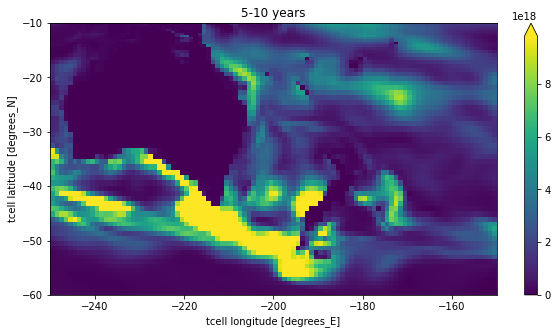

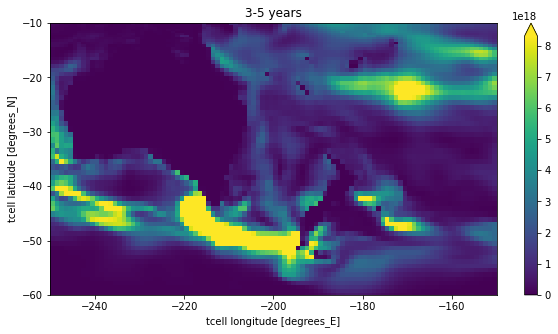

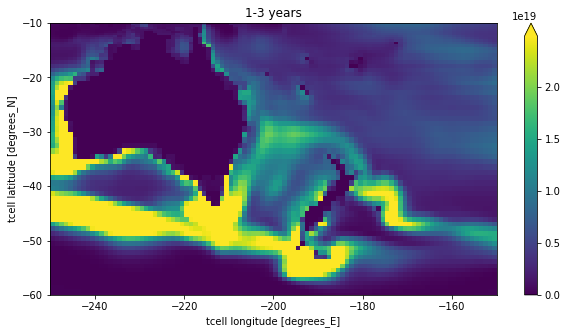

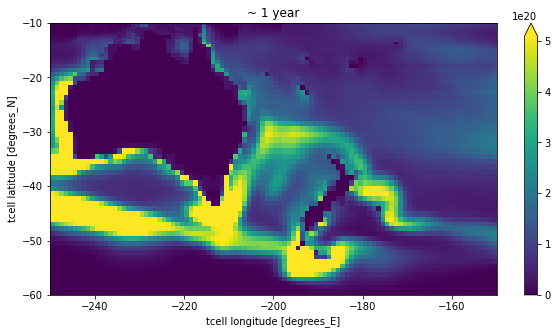

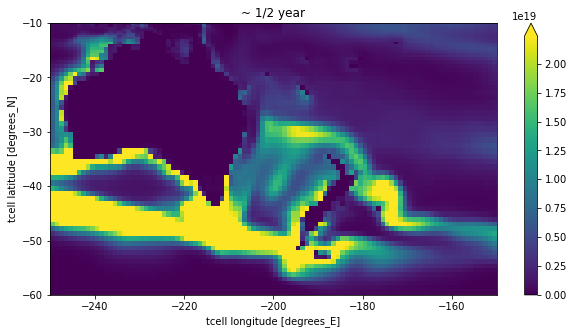

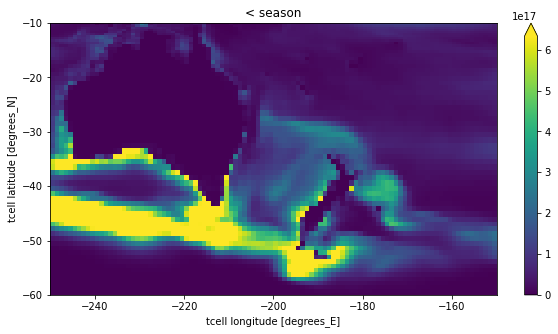

In [22]:
for name, band_slice in bands.items():
    plt.figure(figsize=[10,5])
    MLH_power_spectrum.sel(freq_time=band_slice).mean('freq_time').plot(robust=True)
    plt.xlim([-250, -150])
    plt.ylim([-60, -10])
    plt.title(name)
    

## run the same with MLH climatological anomaly

In [8]:
%%time
# load CAFE60 ETBF metrics
ds_MLH2 = xr.open_zarr('/OSM/CBR/OA_DCFP/work/moo270/ETBF_CAFE_data/ETBF_intermediate_products/CAFE60_MLH.zarr',consolidated=True)
MLH_clim = ds_MLH2.groupby('time.month').mean(dim='time')
MLH_clim = MLH_clim.chunk({'month':12}).compute()
MLH_anom = ds_MLH2.groupby('time.month') - MLH_clim
MLH_anom = MLH_anom.compute()

/scratch1/moo270/miniconda3/envs/pangeo_xgcm/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 30 times more chunks
  return self.array[key]


CPU times: user 929 ms, sys: 542 ms, total: 1.47 s
Wall time: 7.61 s


### convert time axis to integer time counter

In [9]:
integer_months = np.arange(1,1+MLH_anom.time.size,1,dtype=int)
MLH_anom['time'] = integer_months
MLH_anom = MLH_anom.drop('month')

### Compute the power spectrum of MLHanom

In [10]:
# Call the function
MLHanom_calc_power_spectrum = take_power_spectrum(MLH_anom.MLH,'time')

# Take only the real output
MLHanom_power_spectrum = MLHanom_calc_power_spectrum.real

/scratch1/moo270/miniconda3/envs/pangeo_xgcm/lib/python3.9/site-packages/xrft/xrft.py:684: FutureWarning: `real` flag will be deprecated in future version of xrft.power_spectrum and replaced by `real_dim` flag.
  warnings.warn(msg, FutureWarning)
/scratch1/moo270/miniconda3/envs/pangeo_xgcm/lib/python3.9/site-packages/xrft/xrft.py:347: FutureWarning: `real` flag will be deprecated in future version of xrft.dft and replaced by `real_dim` flag.
  warnings.warn(msg, FutureWarning)
/scratch1/moo270/miniconda3/envs/pangeo_xgcm/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


### Load Some Results

So far, all of our calculations have been "lazy".
No computation has actually happened yet.
In order to load some data, we will subset the data to a size that can fit into our notebook's memory.
We select a region in the North Atlantic.

In [26]:
region = dict(yt_ocean=slice(-60,0), xt_ocean=slice(-220, -170))
MLHanom_power_spectrum_SEPAC = MLHanom_calc_power_spectrum.sel(**region)
MLHanom_power_spectrum_SEPAC

<xarray.DataArray (freq_time: 181, yt_ocean: 94, xt_ocean: 50)>
dask.array<getitem, shape=(181, 94, 50), dtype=float64, chunksize=(181, 94, 50), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean   (xt_ocean) float64 -219.5 -218.5 -217.5 ... -172.5 -171.5 -170.5
  * yt_ocean   (yt_ocean) float64 -59.93 -59.22 -58.5 ... -0.5005 -0.1662
  * freq_time  (freq_time) float64 0.0 0.002778 0.005556 ... 0.4944 0.4972 0.5

### compute results

In [27]:
%%time
MLHanom_power_spectrum_SEPAC = MLHanom_power_spectrum_SEPAC.compute()

CPU times: user 239 ms, sys: 265 ms, total: 504 ms
Wall time: 3.57 s


In [28]:
%%time
MLHanom_power_spectrum = MLHanom_power_spectrum.compute()

CPU times: user 359 ms, sys: 402 ms, total: 760 ms
Wall time: 3.3 s


***

## Step 3: Plot Results

### Area Average Power Spectrum

<ipython-input-29-4cf563043430>:15: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axes.set_xlim(xmin=0)


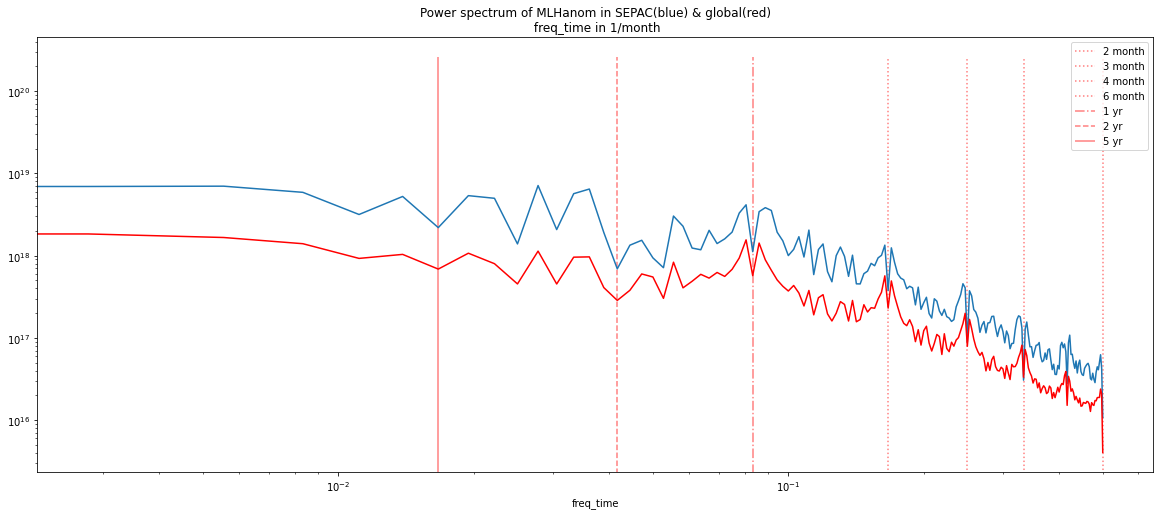

In [29]:
fig, axes = plt.subplots(1, 1, figsize=(20,8))
max_value = MLHanom_power_spectrum_SEPAC.max()
MLHanom_power_spectrum_SEPAC.mean(dim=('xt_ocean', 'yt_ocean')).plot(ax=axes)
MLHanom_power_spectrum.mean(dim=('xt_ocean', 'yt_ocean')).plot(color='r',ax=axes)
plt.title('Power spectrum of MLHanom in SEPAC(blue) & global(red)\n freq_time in 1/month')
axes.set_xscale("log") #scale transformation
axes.set_yscale("log") #scale transformation
axes.vlines((1/2),0,max_value,'r',alpha=0.5,linestyles='dotted', label='2 month')
axes.vlines((1/3),0,max_value,'r',alpha=0.5,linestyles='dotted', label='3 month')
axes.vlines((1/4),0,max_value,'r',alpha=0.5,linestyles='dotted', label='4 month')
axes.vlines((1/6),0,max_value,'r',alpha=0.5,linestyles='dotted', label='6 month')
axes.vlines((1/12),0,max_value,'r',alpha=0.5,linestyles='dashdot', label='1 yr')
axes.vlines((1/24),0,max_value,'r',alpha=0.5,linestyles='dashed', label='2 yr')
axes.vlines((1/60),0,max_value,'r',alpha=0.5,linestyles='solid', label='5 yr')
axes.set_xlim(xmin=0)
axes.legend()

### spectra at a point in the tropics and EAC

<ipython-input-30-8121d5cca63d>:16: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axes.set_xlim(xmin=0)


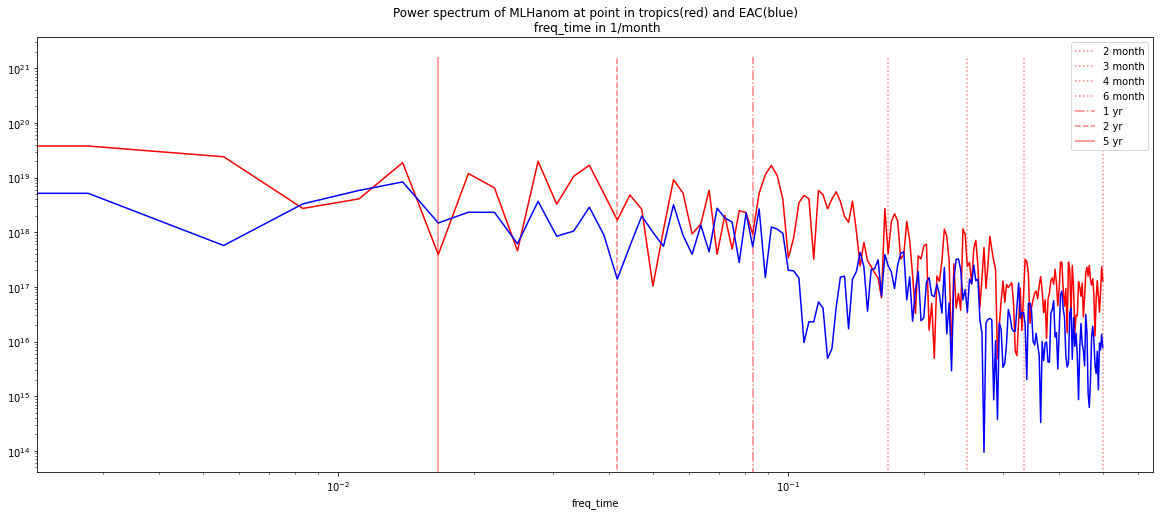

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(20,8))
max_value = MLHanom_power_spectrum.max()

MLHanom_power_spectrum.sel({'xt_ocean':-180.0,'yt_ocean':-5},method='nearest').plot(color='r',ax=axes)
MLHanom_power_spectrum.sel({'xt_ocean':-206.0,'yt_ocean':-27},method='nearest').plot(color='b',ax=axes)
plt.title('Power spectrum of MLHanom at point in tropics(red) and EAC(blue)\n freq_time in 1/month')
axes.set_xscale("log") #scale transformation
axes.set_yscale("log") #scale transformation
axes.vlines((1/2),0,max_value,'r',alpha=0.5,linestyles='dotted', label='2 month')
axes.vlines((1/3),0,max_value,'r',alpha=0.5,linestyles='dotted', label='3 month')
axes.vlines((1/4),0,max_value,'r',alpha=0.5,linestyles='dotted', label='4 month')
axes.vlines((1/6),0,max_value,'r',alpha=0.5,linestyles='dotted', label='6 month')
axes.vlines((1/12),0,max_value,'r',alpha=0.5,linestyles='dashdot', label='1 yr')
axes.vlines((1/24),0,max_value,'r',alpha=0.5,linestyles='dashed', label='2 yr')
axes.vlines((1/60),0,max_value,'r',alpha=0.5,linestyles='solid', label='5 yr')
axes.set_xlim(xmin=0)
axes.legend()

### Maps of different frequency band averages

In [11]:
bands = {
    "5-10 years": slice(1/120, 1/60),
    "7-10 years": slice(1/120, 1/84),
    "5-7 years": slice(1/84, 1/60),
    "5 years": slice(1/61,1/59),
    "3-5 years": slice(1/60, 1/36),
    "3 years": slice(1/37, 1/35),
    "1-3 years": slice(1/36, 1/12),
    "~ 1 year": slice(1/13, 1/11),
    "~ 1/2 year": slice(1/7, 1/5),
    "< season": slice(1/3, None)
}

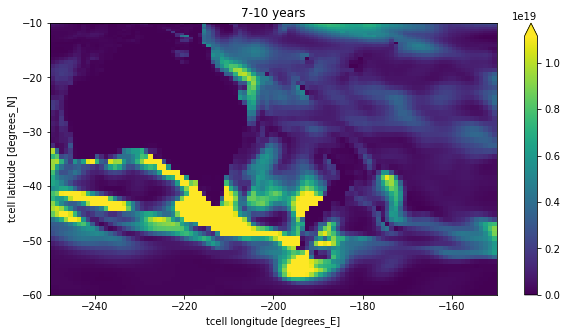

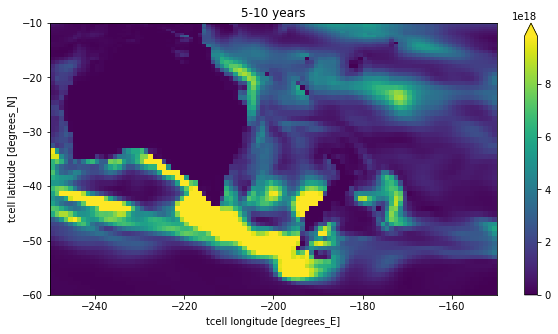

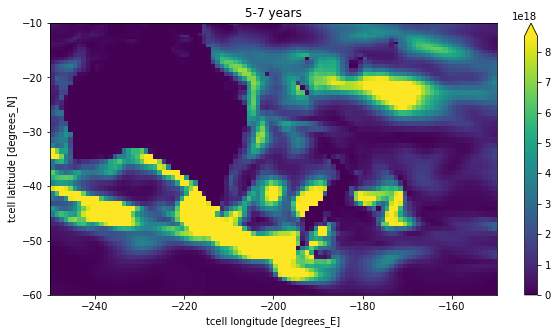

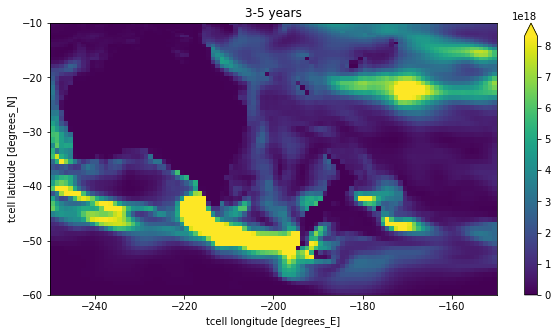

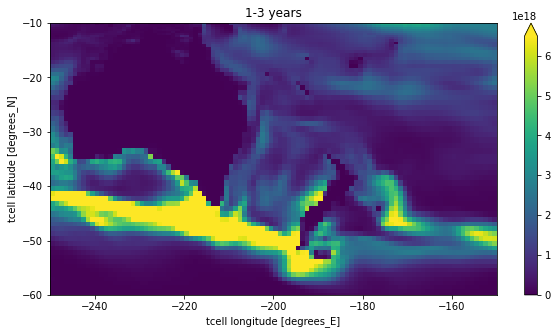

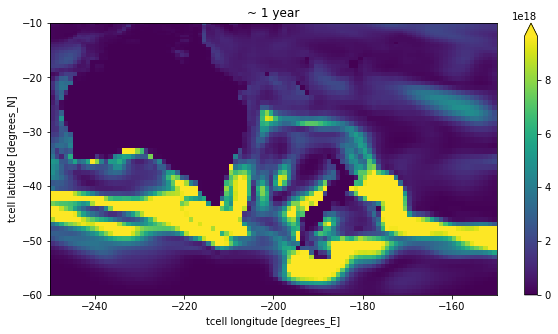

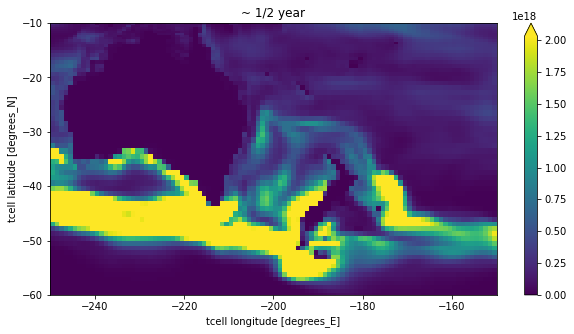

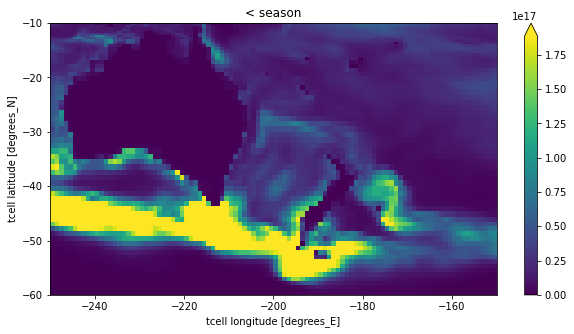

In [34]:
for name, band_slice in bands.items():
    plt.figure(figsize=[10,5])
    MLHanom_power_spectrum.sel(freq_time=band_slice).mean('freq_time').plot(robust=True)
    plt.xlim([-250, -150])
    plt.ylim([-60, -10])
    plt.title(name)

# Normalisation
## $x_{norm} = \frac{x - x_{min}}{x_{max}-x_{min}}$

In [12]:
MLHanom_norm = ( MLH_anom - MLH_anom.min(dim=['xt_ocean','yt_ocean'])) / (MLH_anom.max(dim=['xt_ocean','yt_ocean']) - MLH_anom.min(dim=['xt_ocean','yt_ocean']))

In [13]:
# Call the function
MLHanom_norm_power_spectrum = take_power_spectrum(MLHanom_norm.MLH,'time')

# Take only the real output
MLHanom_norm_power_spectrum = MLHanom_norm_power_spectrum.real

/scratch1/moo270/miniconda3/envs/pangeo_xgcm/lib/python3.9/site-packages/xrft/xrft.py:684: FutureWarning: `real` flag will be deprecated in future version of xrft.power_spectrum and replaced by `real_dim` flag.
  warnings.warn(msg, FutureWarning)
/scratch1/moo270/miniconda3/envs/pangeo_xgcm/lib/python3.9/site-packages/xrft/xrft.py:347: FutureWarning: `real` flag will be deprecated in future version of xrft.dft and replaced by `real_dim` flag.
  warnings.warn(msg, FutureWarning)
/scratch1/moo270/miniconda3/envs/pangeo_xgcm/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


In [14]:
%time
MLHanom_norm_power_spectrum = MLHanom_norm_power_spectrum.compute()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs


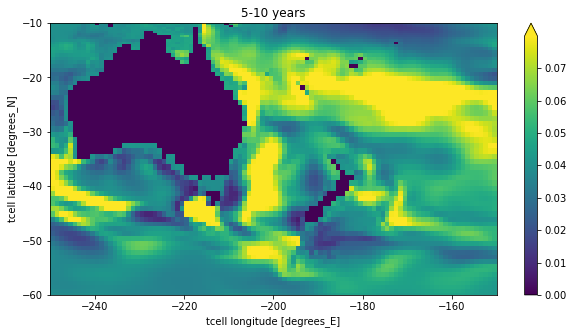

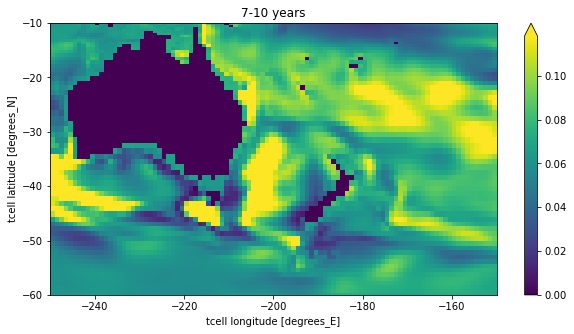

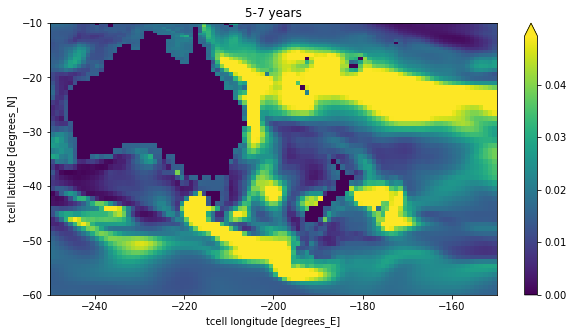

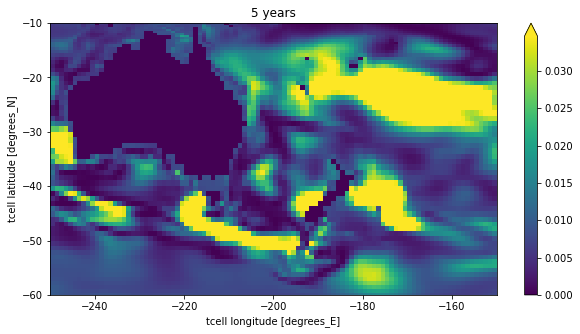

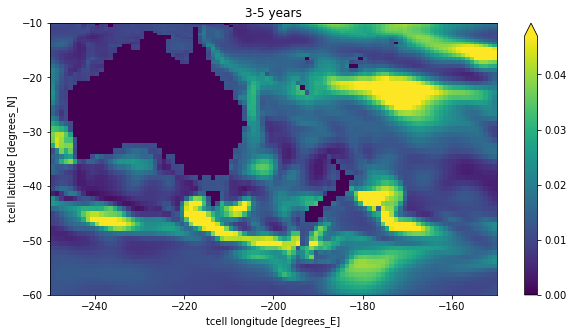

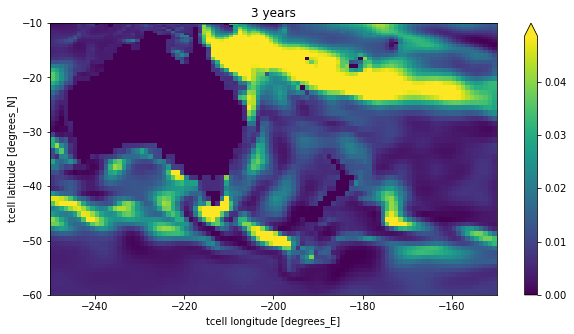

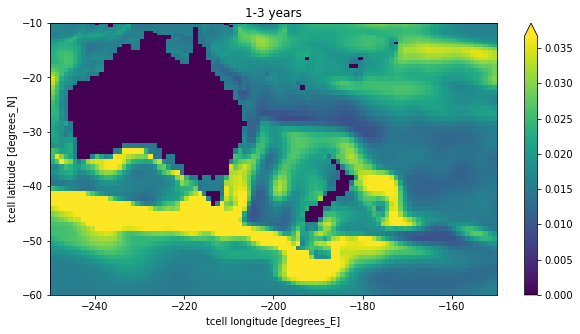

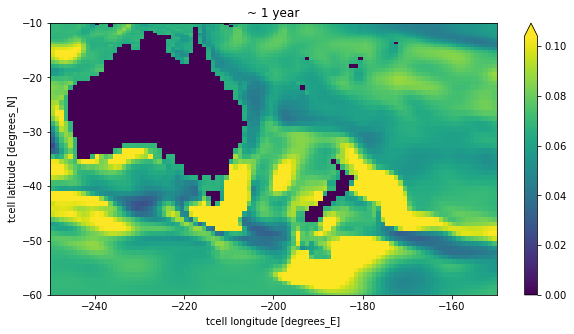

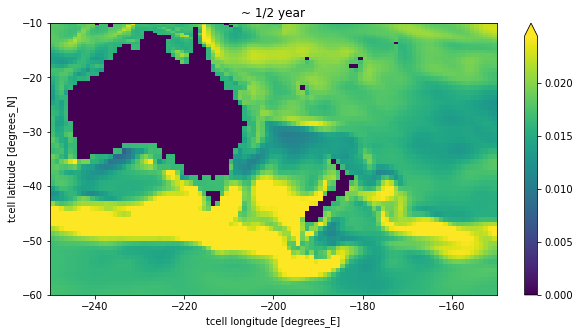

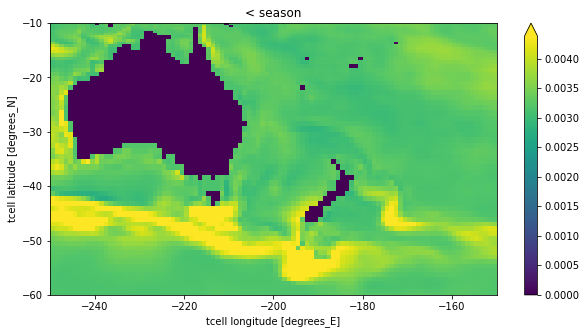

In [15]:
for name, band_slice in bands.items():
    plt.figure(figsize=[10,5])
    MLHanom_norm_power_spectrum.sel(freq_time=band_slice).mean('freq_time').plot(robust=True)
    plt.xlim([-250, -150])
    plt.ylim([-60, -10])
    plt.title(name)

# generate some masks from these results above

In [16]:
mask_base = MLHanom_norm_power_spectrum.sel(freq_time=slice(1/84, 1/60)).mean('freq_time')

Text(0.5, 1.0, 'mask base : 5-7 year band\n contoured region')

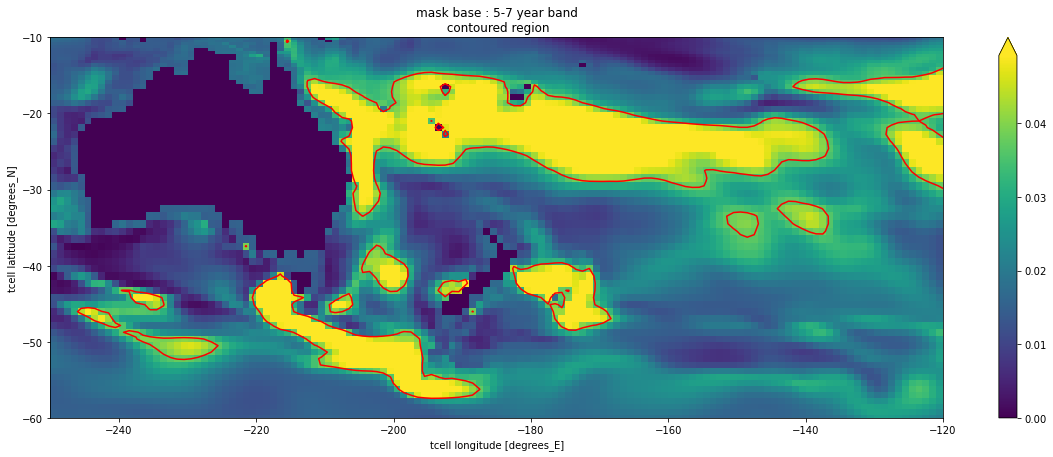

In [17]:
plt.figure(figsize=[20,7])
mask_base.plot.contour(levels=[0.037],colors=['red'])
mask_base.plot(robust=True)
plt.xlim([-250, -120])
plt.ylim([-60, -10])
plt.title('mask base : 5-7 year band\n contoured region')

In [18]:
mask1 = xr.where(mask_base >= 0.037,True,False)

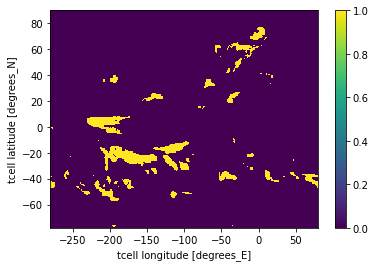

In [19]:
mask1.plot()

In [20]:
mask2 = mask1.where((mask1.yt_ocean >= -35) & 
                    (mask1.yt_ocean <= -12) & 
                    (mask1.xt_ocean >= -220) &
                    (mask1.xt_ocean <= -160),
                   ).fillna(False)

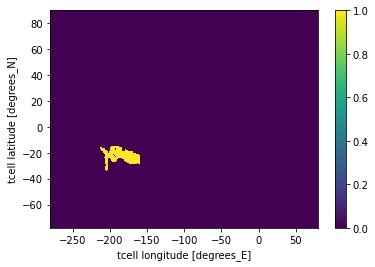

In [21]:
mask2.plot()

Text(0.5, 1.0, 'mask from 5-7 year band MLH')

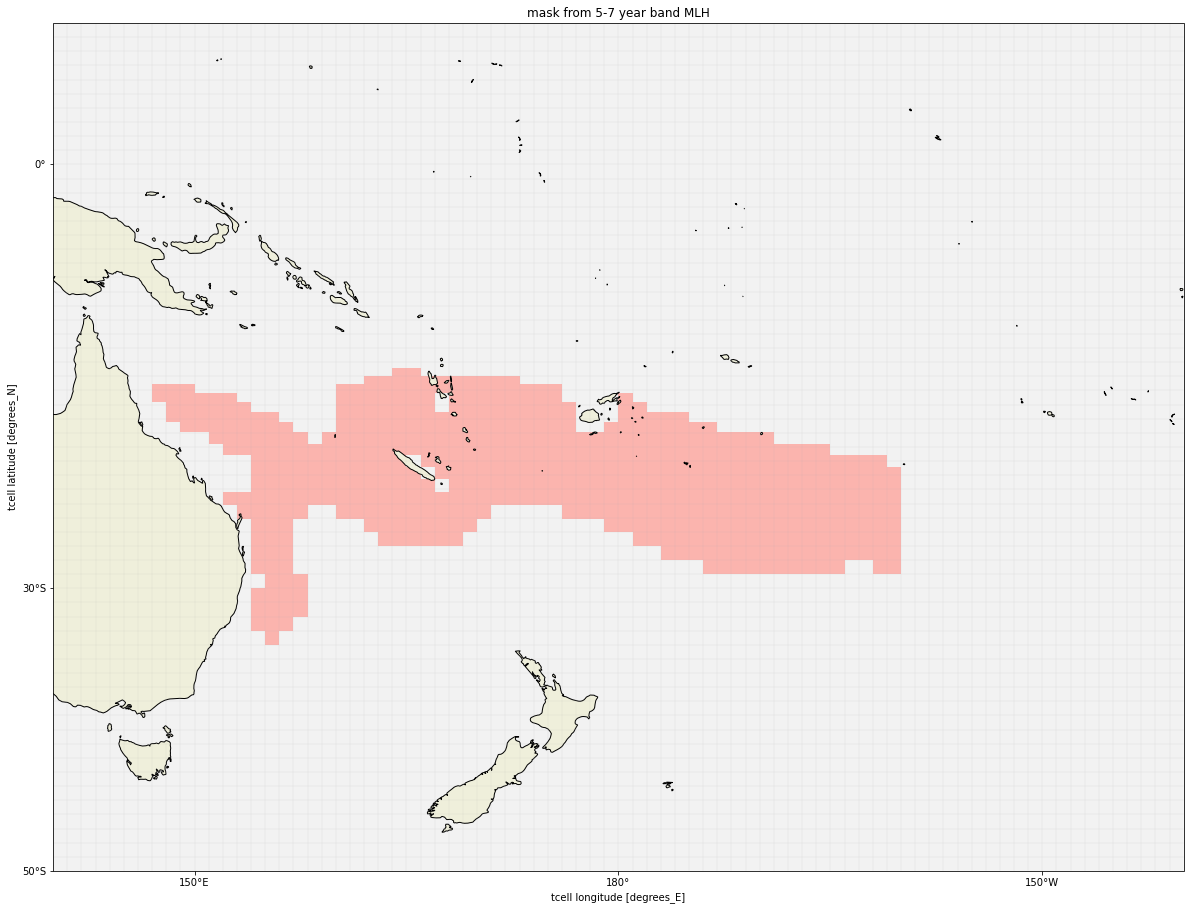

In [22]:
import numpy as np
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd

long_list = np.arange(-180, 180, 1)
lat_list = np.arange(-90, 90, 1)

value_dict = {'latitude':[0,0,-20,-20,-40,-50],
              'longitude':[179,181,179,181,-170,190]}
df = pd.DataFrame(value_dict)

proj = ccrs.PlateCarree(central_longitude=180)

fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16,16))
mask2.plot(ax=ax,transform=ccrs.PlateCarree(),cmap='Pastel1_r',add_colorbar=False)
ax.set_extent([140, 220, -50, 10], crs=ccrs.PlateCarree())


fig.canvas.draw()
fig.tight_layout()
resolution='50m'
land = cartopy.feature.NaturalEarthFeature('physical', 'land', \
    scale=resolution, edgecolor='k', facecolor=cfeature.COLORS['land'])
ax.add_feature(land)


#ax.scatter(df['longitude'].values.tolist(), df['latitude'].values.tolist(),transform=ccrs.PlateCarree(),color='r')

gl = ax.gridlines(crs=proj, draw_labels=False, alpha=0.5, linewidth=0.25)
gl.xlocator = mticker.FixedLocator(long_list)
gl.ylocator = mticker.FixedLocator(lat_list)

ax.set_xticks([150, 180, 210], crs=ccrs.PlateCarree())
ax.set_yticks([-50,-30, 0], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

plt.title('mask from 5-7 year band MLH')

In [23]:
mask_MLH_5_7yr = mask2

Text(0.5, 1.0, 'masked $MLH_{mlt}$ \n 5-7 year band')

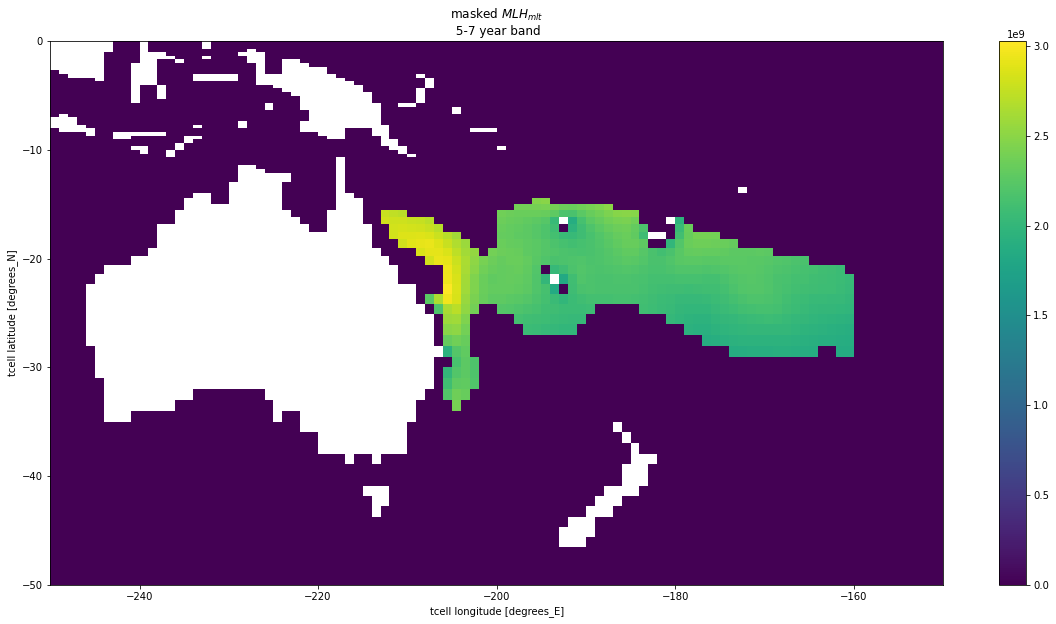

In [24]:
plt.figure(figsize=[20,10])
(ds_MLH2.MLH.isel(time=0)*mask_MLH_5_7yr).plot()
plt.xlim([-250, -150])
plt.ylim([-50, 0])
plt.title('masked $MLH_{mlt}$ \n 5-7 year band')

In [25]:
masked_MLH = (ds_MLH2.MLH*mask_MLH_5_7yr)
masked_MLH = masked_MLH.where(masked_MLH !=0)

Text(0.5, 1.0, 'masked $MLH_{mlt}$ \n 5-7 year band')

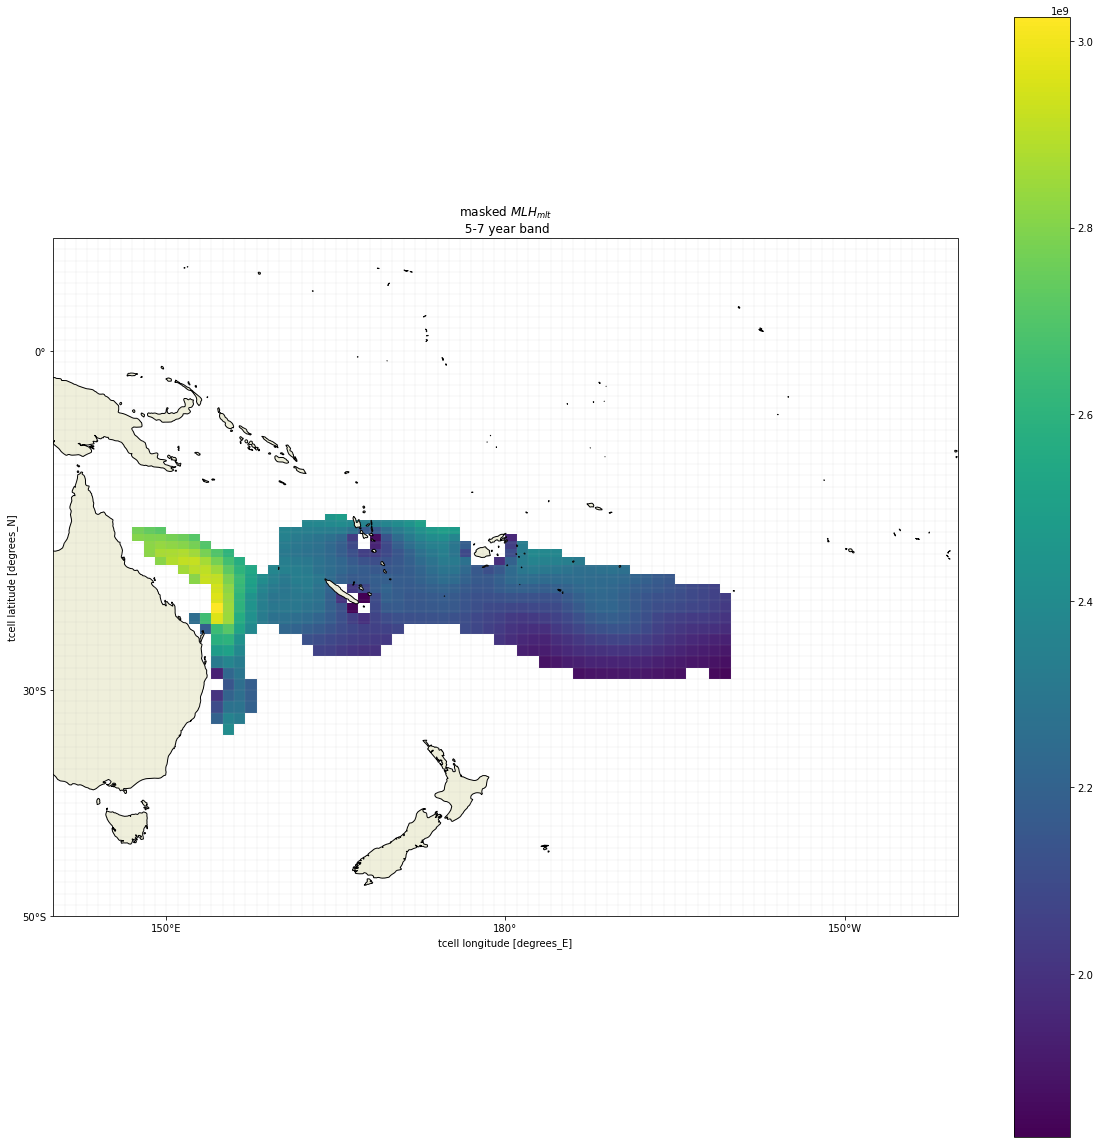

In [26]:
import numpy as np
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd

long_list = np.arange(-180, 180, 1)
lat_list = np.arange(-90, 90, 1)

value_dict = {'latitude':[0,0,-20,-20,-40,-50],
              'longitude':[179,181,179,181,-170,190]}
df = pd.DataFrame(value_dict)

proj = ccrs.PlateCarree(central_longitude=180)

fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=(16,16))
masked_MLH.isel(time=0).plot(ax=ax,transform=ccrs.PlateCarree())
ax.set_extent([140, 220, -50, 10], crs=ccrs.PlateCarree())


fig.canvas.draw()
fig.tight_layout()
resolution='50m'
land = cartopy.feature.NaturalEarthFeature('physical', 'land', \
    scale=resolution, edgecolor='k', facecolor=cfeature.COLORS['land'])
ax.add_feature(land)


#ax.scatter(df['longitude'].values.tolist(), df['latitude'].values.tolist(),transform=ccrs.PlateCarree(),color='r')

gl = ax.gridlines(crs=proj, draw_labels=False, alpha=0.5, linewidth=0.25)
gl.xlocator = mticker.FixedLocator(long_list)
gl.ylocator = mticker.FixedLocator(lat_list)

ax.set_xticks([150, 180, 210], crs=ccrs.PlateCarree())
ax.set_yticks([-50,-30, 0], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

plt.title('masked $MLH_{mlt}$ \n 5-7 year band')

# use the masks to create weighted timeseries of $MLH_{mlt}$

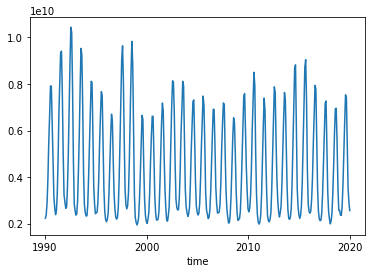

In [27]:
masked_MLH.mean(['yt_ocean','xt_ocean']).plot()

In [28]:
CAFE_grid_info = '/OSM/CBR/OA_DCFP/work/moo270/data_refs/CAFE_grid_info/cafe60_ocean_grid_info.zarr'
CAFE_ocean_grid_info = xr.open_zarr(CAFE_grid_info,consolidated=True)
area_weights_t = CAFE_ocean_grid_info.area_t

In [29]:
unweighted_timeseries = masked_MLH.mean(['yt_ocean','xt_ocean'])
timeseries = helper.weighted_ocean_mean(masked_MLH,weights=area_weights_t,dim=['yt_ocean','xt_ocean'])

In [30]:
clim = timeseries.groupby('time.month').mean('time')
anom = timeseries.groupby('time.month') - clim

/scratch1/moo270/miniconda3/envs/pangeo_xgcm/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 30 times more chunks
  return self.array[key]


Text(0.5, 1.0, 'SEC & Coral sea mean MLH monthly anomaly\n year rolling mean')

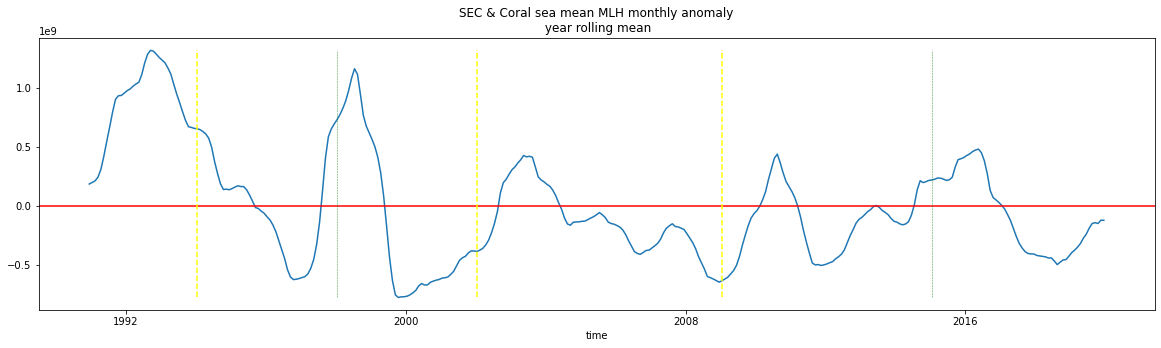

In [31]:
import cftime
ax = anom.rolling(time=12).mean().plot(figsize=(20,5))
plt.axhline(color='r')
ymin = anom.rolling(time=12).mean().min().compute()
ymax = anom.rolling(time=12).mean().max().compute()

plt.plot([cftime.DatetimeJulian(1998, 1, 16), cftime.DatetimeJulian(1998, 1, 16)],
         [ymin,ymax],
         color='green',linewidth=0.5,alpha=0.8,linestyle='--')
plt.plot([cftime.DatetimeJulian(2015, 1, 16), cftime.DatetimeJulian(2015, 1, 16)],
         [ymin,ymax],
         color='green',linewidth=0.5,alpha=0.8,linestyle='--')
plt.plot([cftime.DatetimeJulian(1994, 1, 16), cftime.DatetimeJulian(1994, 1, 16)],
         [ymin,ymax],
         color='yellow',linewidth=1.5,alpha=1,linestyle='--')
plt.plot([cftime.DatetimeJulian(2002, 1, 16), cftime.DatetimeJulian(2002, 1, 16)],
         [ymin,ymax],
         color='yellow',linewidth=1.5,alpha=1,linestyle='--')
plt.plot([cftime.DatetimeJulian(2009, 1, 16), cftime.DatetimeJulian(2009, 1, 16)],
         [ymin,ymax],
         color='yellow',linewidth=1.5,alpha=1,linestyle='--')


plt.title('SEC & Coral sea mean MLH monthly anomaly\n year rolling mean')

# add SOI background

In [36]:
SOI = xr.open_dataset('/OSM/CBR/OA_DCFP/work/moo270/observations/SOI_NCAR_Trenberth.nc')
SOI_df = SOI.to_dataframe()
# make string version of original column, call it 'col'
SOI_df['time_str'] = SOI_df.index.astype(str)

# make the new columns using string indexing
SOI_df['year_str'] = SOI_df['time_str'].str[0:4]
SOI_df['month_str'] = SOI_df['time_str'].str[4:6]
SOI_df['datetime_str'] = SOI_df['year_str'] + '-' + SOI_df['month_str']
SOI_df = SOI_df[(SOI_df.TIME < 2020.0) & (SOI_df.TIME >= 1990.0)].dropna(how='all')
SOI_df['time'] = anom.time
SOI_df.set_index('time',inplace=True)
SOI_ds = xr.Dataset.from_dataframe(SOI_df)

<ipython-input-59-73059e9e957c>:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = anom.indexes['time'].to_datetimeindex()
<ipython-input-59-73059e9e957c>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(datetimeindex.values, ax.get_ylim(),SOI_ds.SOI_SIGNAL.rolling(time=6,center=True).mean().values[np.newaxis],cmap='cmo.balance', alpha=0.2)


Text(0.5, 1.0, 'SEC & Coral sea mean MLH monthly anomaly\n SOI background\n year rolling mean')

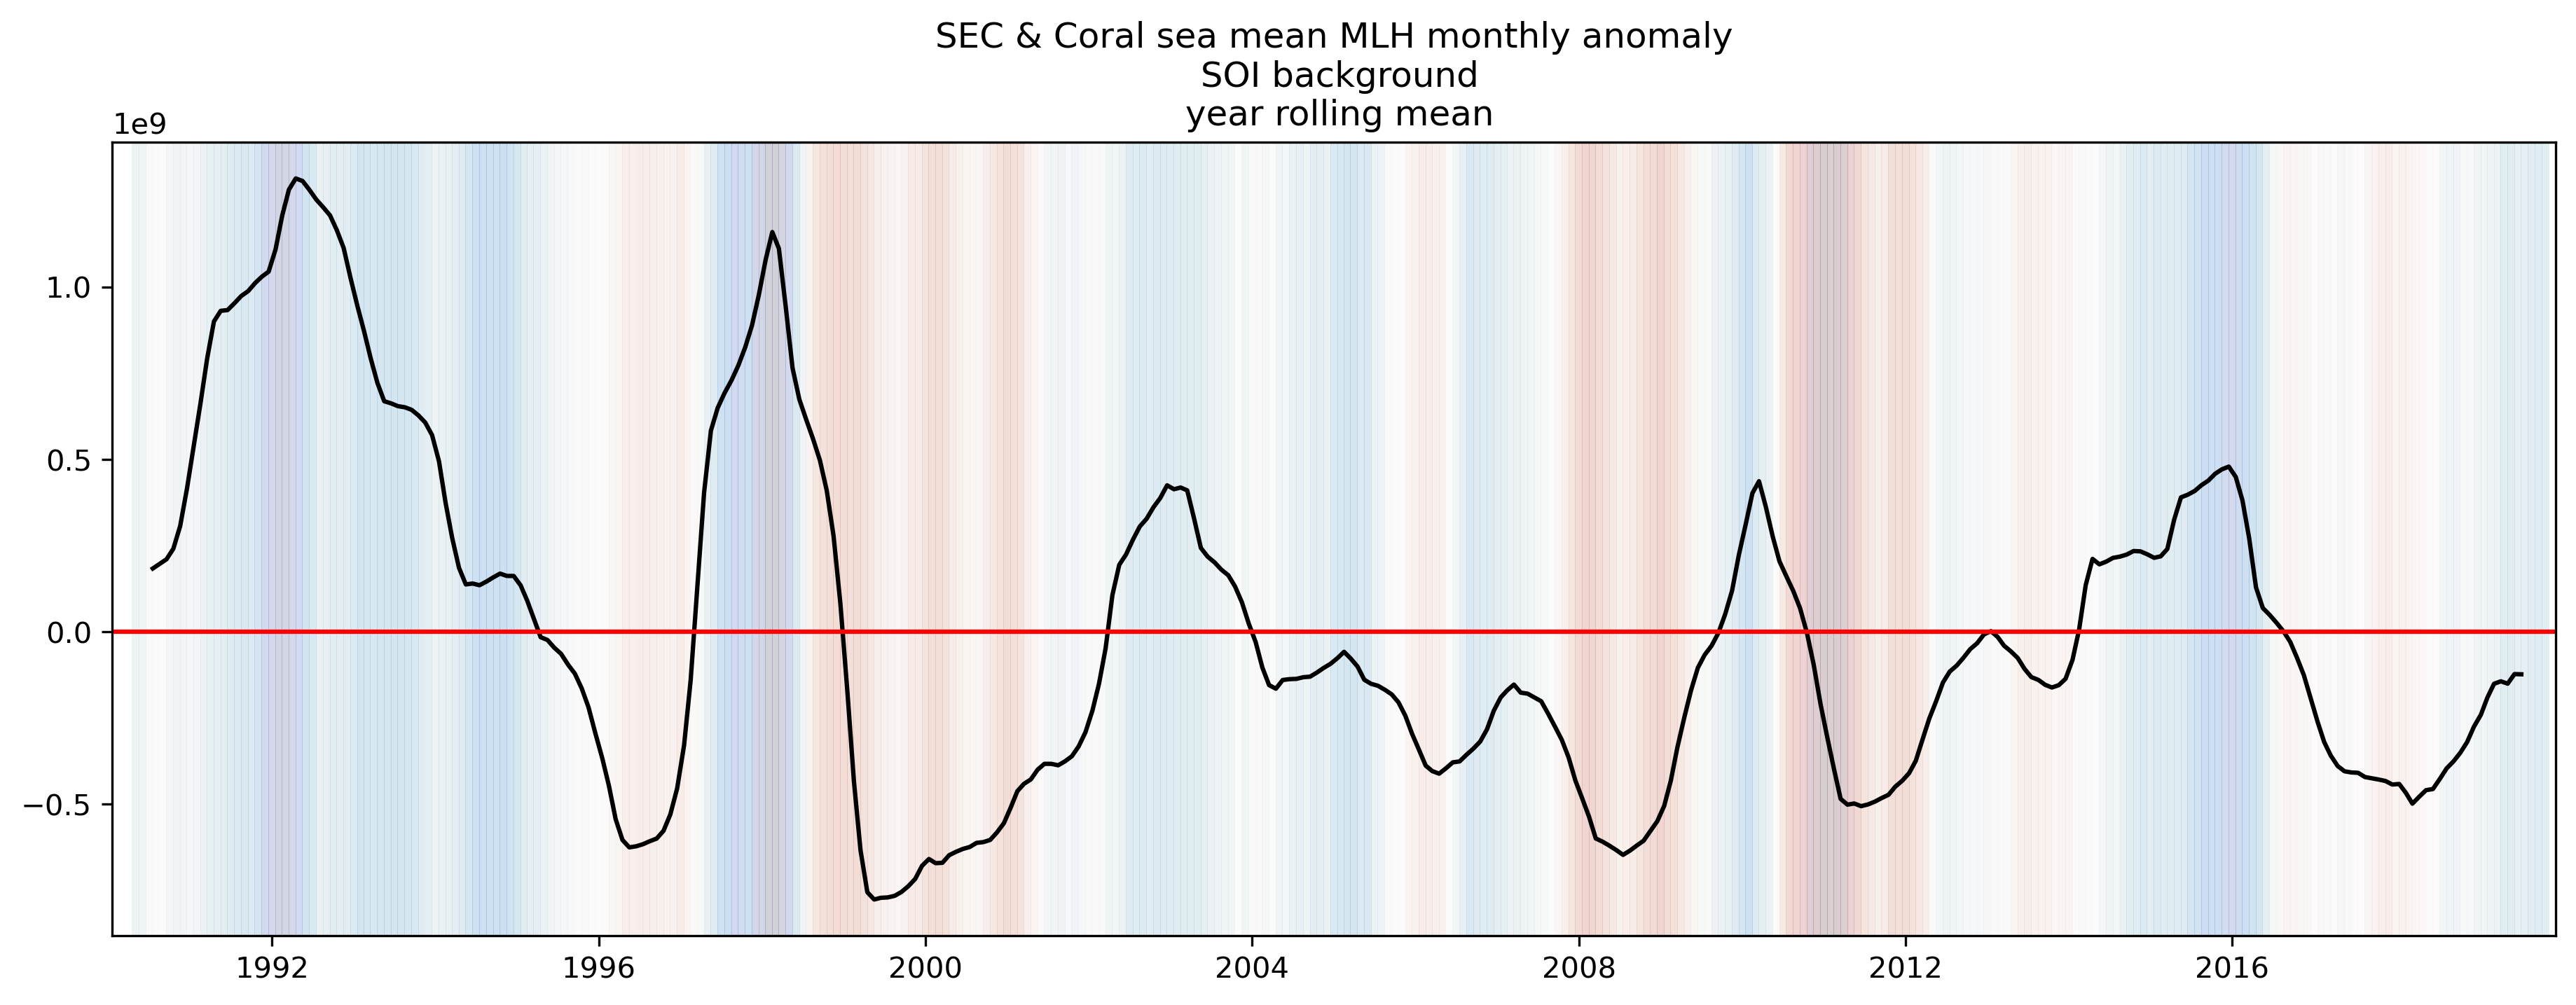

In [59]:
import cmocean
import cmocean.cm as cmo
datetimeindex = anom.indexes['time'].to_datetimeindex()
fig = plt.figure(figsize=(15, 5), dpi= 300, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.plot(datetimeindex,anom.rolling(time=12, center=True).mean(),color='black')
plt.axhline(color='r')
ymin = anom.rolling(time=12).mean().min().compute()
ymax = anom.rolling(time=12).mean().max().compute()

plt.pcolor(datetimeindex.values, ax.get_ylim(),SOI_ds.SOI_SIGNAL.rolling(time=6,center=True).mean().values[np.newaxis],cmap='cmo.balance', alpha=0.2)


plt.title('SEC & Coral sea mean MLH monthly anomaly\n SOI background\n year rolling mean')

## export timeseries

In [36]:
masked_MLH = masked_MLH.rename('masked_MLH')
anom = anom.rename('masked_MLH_anom')
clim = clim.rename('masked_MLH_clim')
ds_masked_export = xr.merge([masked_MLH,anom,clim])

In [39]:
ds_masked_export.to_netcdf('/OSM/CBR/OA_DCFP/work/moo270/project_datasets/timeseries/MLH_tropics_timeseries_5_7yr_band.nc')